In [1]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import auc

from nilearn.image import threshold_img
from nilearn.datasets import load_mni152_template

from neurovlm.data import data_dir, load_masker
from neurovlm.models import load_model
from neurovlm.train import which_device
from neurovlm.metrics import recall_curve

## Brain-to-Text Generation: Evaluation

In [2]:
device = which_device()
autoencoder = load_model("autoencoder").to(device)
proj_head = load_model("proj_head_text_mse").to(device)
proj_head_text = load_model("proj_head_text_infonce").to(device)
proj_head_img = load_model("proj_head_image_infonce").to(device)
specter = load_model("specter").to(device)
masker = load_masker()

There are adapters available but none are activated for the forward pass.


In [3]:
# generated in 11_neurovault_decoding.ipynb
df_pubs = pd.read_csv(data_dir / "neuro_vault_brain_to_text.csv")
nv = torch.load(data_dir / "neurovault.pt", weights_only=False)
df_nv = nv["df_pubs"]

# union
df_nv = df_nv[df_nv["doi"].isin(df_pubs["doi"])]
df_pubs = df_pubs[df_pubs["doi"].isin(df_nv["doi"])]
assert (df_nv["doi"].values == df_pubs["doi"].values).all()

# embed
with torch.no_grad():
    text_emb = F.normalize(proj_head_text(F.normalize(nv["text_emb_titles_abstracts"].to(device))), dim=1)
    text_emb_gen = F.normalize(proj_head_text(F.normalize(specter(df_pubs["brain_to_text_summary"].tolist()), dim=1)), dim=1)

t_to_i_textgen, i_to_t_textgen = recall_curve(text_emb.cpu(), text_emb_gen.cpu())

In [4]:
brain_to_text_summary = []
brain_to_title = []
for i in df_pubs['brain_to_text_summary']:
    if "SEP" not in i:
        brain_to_text_summary.append(i.replace("\n", " [SEP] ", 1).replace("\n", "").strip())
    else:
        brain_to_text_summary.append(i.replace("\n", "").strip())
    brain_to_title.append(brain_to_text_summary[-1].split(" [SEP] ")[0].strip())

df_pubs["brain_to_text_summary"] = brain_to_text_summary
df_pubs["generated_titles"] = brain_to_title
df_pubs["text_sim"] = torch.diag(text_emb @ text_emb_gen.T).cpu().numpy()

with torch.no_grad():
    text_emb_titles = F.normalize(proj_head_text(F.normalize(nv["text_emb_titles"].to(device))), dim=1)
    text_emb_gen_titles = F.normalize(proj_head_text(F.normalize(specter(df_pubs["generated_titles"].tolist()), dim=1)), dim=1)
df_pubs["titles_sim"] = torch.diag(text_emb_titles @ text_emb_gen_titles.T).cpu().numpy()

df_pubs.sort_values(by="text_sim", ascending=False).to_csv(data_dir / "brain_to_text_gen.csv", index=False)

In [5]:
df_pubs = pd.read_csv(data_dir / "brain_to_text_gen.csv")
nv = torch.load(data_dir / "neurovault.pt", weights_only=False)
df_nv = nv["df_pubs"]
df_neuro = nv["df_neuro"]

# union
df_nv = df_nv[df_nv["doi"].isin(df_pubs["doi"])]
df_pubs = df_pubs[df_pubs["doi"].isin(df_nv["doi"])]
df_neuro = df_neuro[df_neuro["doi"].isin(df_nv["doi"])]

# align row order
order = df_nv["doi"].reset_index(drop=True)
rank = pd.Series(range(len(order)), index=order)
df_pubs = (
    df_pubs
    .assign(_rank=df_pubs["doi"].map(rank))
    .sort_values("_rank", kind="stable")
    .drop(columns="_rank")
    .reset_index(drop=True)
)

df_pubs.reset_index(inplace=True, drop=True)
df_neuro.reset_index(inplace=True, drop=True)

assert (df_nv["doi"].values == df_pubs["doi"].values).all()

text_emb = F.normalize(nv["text_emb_titles_abstracts"].to(device), dim=1)

df_pubs.shape, df_neuro.shape, nv['neuro_clustered'].shape, text_emb.shape

((312, 7), (3183, 6), (3183, 28542), torch.Size([312, 768]))

In [6]:
# Generate maps from text
with torch.no_grad():
    imgs_gen = torch.sigmoid(autoencoder.decoder(proj_head(text_emb))) # text-to-brain

# Cluster generated activation maps
def cluster(i, arr):
    thr_img = threshold_img(
        masker.inverse_transform(arr), "99%",
        cluster_threshold=50, two_sided=False, copy_header=True
    )
    vec = masker.transform(thr_img)
    return i, vec.astype(np.float32, copy=False)

results = Parallel(n_jobs=16, backend="loky")(
    delayed(cluster)(i, arr) for i, arr in
    enumerate(tqdm(imgs_gen.cpu().numpy(), total=len(imgs_gen)))
)
imgs_gen_clustered = np.zeros((len(imgs_gen), 28542), dtype=np.float32)
for i, vec in results:
    imgs_gen_clustered[i] = vec

imgs = nv['neuro'].float()
imgs_clustered = torch.from_numpy(nv["neuro_clustered"])

  0%|          | 0/312 [00:00<?, ?it/s]

In [20]:
with torch.no_grad():
    neuro_latent_pred = proj_head_img(autoencoder.encoder((torch.from_numpy(imgs_gen_clustered) > 0).float().to(device)))
    neuro_latent_true = proj_head_img(autoencoder.encoder((imgs_clustered.to(device) > 0).float()))
neuro_latent_pred = F.normalize(neuro_latent_pred.to("cpu"), dim=1)
neuro_latent_true = F.normalize(neuro_latent_true.to("cpu"), dim=1)

imgs_gen_clust = []
imgs_true_orig = torch.zeros((len(df_pubs), 28542))
imgs_true = torch.zeros((len(df_pubs), 28542))
imax = torch.zeros(len(df_pubs))
neuro_latent_true_sel = torch.zeros((len(df_pubs), 384))

for i, doi in tqdm(enumerate(df_pubs["doi"]), total=len(df_pubs)):
    mask = df_neuro[df_neuro["doi"] == doi].index.values
    sim = neuro_latent_true[mask] @ neuro_latent_pred[i]

    # select most similar image
    ind = sim.argsort(descending=True)[0]
    imax[i] = df_neuro[df_neuro["doi"] == doi].index.values[ind]
    neuro_latent_true_sel[i] = neuro_latent_true[mask][ind]
    
    # for plotting
    imgs_true[i] = imgs_clustered[ind]
    imgs_true_orig[i] = imgs[ind]

  0%|          | 0/312 [00:00<?, ?it/s]

Text(0.5, 1.0, 'NeuroVault Generative Alignment: Recall')

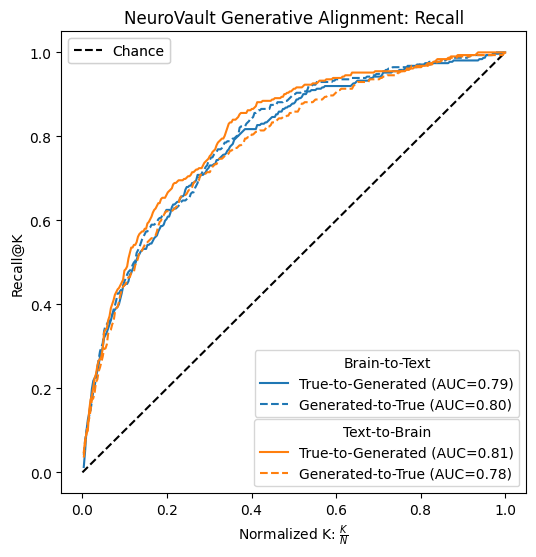

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))

# --- Text-to-Brain (orange / C1) ---
x0 = np.arange(1, len(t_to_i_textgen) + 1) / len(t_to_i_textgen)

auc_btt_tg = auc(x0, t_to_i_textgen)
auc_btt_gt = auc(x0, i_to_t_textgen)

ax.plot(x0, t_to_i_textgen, color="C0", ls="-",  label="_nolegend_")
ax.plot(x0, i_to_t_textgen, color="C0", ls="--", label="_nolegend_")
ax.plot([0, 1], [0, 1], color="k", ls="--", label="Chance")

# --- Brain-to-Text (blue / C0) ---
t_to_i, i_to_t = recall_curve(neuro_latent_true_sel.cpu(), neuro_latent_pred.cpu())
x1 = np.arange(1, len(t_to_i) + 1) / len(t_to_i)

auc_ttb_tg = auc(x1, t_to_i)
auc_ttb_gt = auc(x1, i_to_t)

ax.plot(x1, t_to_i, color="C1", ls="-",  label="_nolegend_")
ax.plot(x1, i_to_t, color="C1", ls="--", label="_nolegend_")

# --- Two grouped legends ---
btt_handles = [
    Line2D([0], [0], color="C0", ls="-"),
    Line2D([0], [0], color="C0", ls="--"),
]
btt_labels = [
    f"True-to-Generated (AUC={auc_btt_tg:.2f})",
    f"Generated-to-True (AUC={auc_btt_gt:.2f})",
]

ttb_handles = [
    Line2D([0], [0], color="C1", ls="-"),
    Line2D([0], [0], color="C1", ls="--"),
]
ttb_labels = [
    f"True-to-Generated (AUC={auc_ttb_tg:.2f})",
    f"Generated-to-True (AUC={auc_ttb_gt:.2f})",
]


leg1 = ax.legend(ttb_handles, ttb_labels, title="Text-to-Brain",
                 loc="lower right", bbox_to_anchor=(1.0, 0.),frameon=True)
ax.add_artist(leg1)  # keep the first legend

leg2 = ax.legend(btt_handles, btt_labels, title="Brain-to-Text",
                 loc="lower right", bbox_to_anchor=(1.0, 0.15), frameon=True)
ax.add_artist(leg2)

leg3 = ax.legend()
ax.add_artist(leg3)

ax.set_ylabel("Recall@K")
ax.set_xlabel(r"Normalized K: $\frac{K}{N}$")
ax.set_title("NeuroVault Generative Alignment: Recall")
# plt.savefig(data_dir / "contrastive_recall_gen.svg", dpi=300)

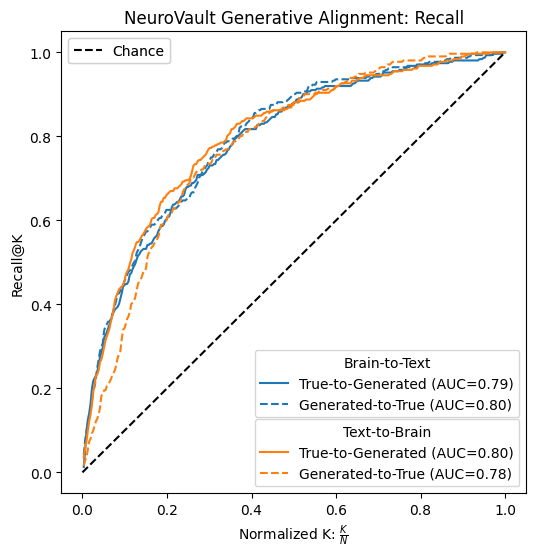

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

# --- Text-to-Brain (orange / C1) ---
x0 = np.arange(1, len(t_to_i_textgen) + 1) / len(t_to_i_textgen)

auc_btt_tg = auc(x0, t_to_i_textgen)
auc_btt_gt = auc(x0, i_to_t_textgen)

ax.plot(x0, t_to_i_textgen, color="C0", ls="-",  label="_nolegend_")
ax.plot(x0, i_to_t_textgen, color="C0", ls="--", label="_nolegend_")
ax.plot([0, 1], [0, 1], color="k", ls="--", label="Chance")

# --- Brain-to-Text (blue / C0) ---
t_to_i, i_to_t = recall_curve(neuro_latent_true_sel.cpu(), neuro_latent_pred.cpu())
x1 = np.arange(1, len(t_to_i) + 1) / len(t_to_i)

auc_ttb_tg = auc(x1, t_to_i)
auc_ttb_gt = auc(x1, i_to_t)

ax.plot(x1, t_to_i, color="C1", ls="-",  label="_nolegend_")
ax.plot(x1, i_to_t, color="C1", ls="--", label="_nolegend_")

# --- Two grouped legends ---
btt_handles = [
    Line2D([0], [0], color="C0", ls="-"),
    Line2D([0], [0], color="C0", ls="--"),
]
btt_labels = [
    f"True-to-Generated (AUC={auc_btt_tg:.2f})",
    f"Generated-to-True (AUC={auc_btt_gt:.2f})",
]

ttb_handles = [
    Line2D([0], [0], color="C1", ls="-"),
    Line2D([0], [0], color="C1", ls="--"),
]
ttb_labels = [
    f"True-to-Generated (AUC={auc_ttb_tg:.2f})",
    f"Generated-to-True (AUC={auc_ttb_gt:.2f})",
]


leg1 = ax.legend(ttb_handles, ttb_labels, title="Text-to-Brain",
                 loc="lower right", bbox_to_anchor=(1.0, 0.),frameon=True)
ax.add_artist(leg1)  # keep the first legend

leg2 = ax.legend(btt_handles, btt_labels, title="Brain-to-Text",
                 loc="lower right", bbox_to_anchor=(1.0, 0.15), frameon=True)
ax.add_artist(leg2)

leg3 = ax.legend()
ax.add_artist(leg3)

ax.set_ylabel("Recall@K")
ax.set_xlabel(r"Normalized K: $\frac{K}{N}$")
ax.set_title("NeuroVault Generative Alignment: Recall")
# plt.savefig(data_dir / "contrastive_recall_gen.png", dpi=300)
plt.savefig(data_dir / "contrastive_recall_gen.svg", dpi=300)

In [22]:
import nibabel as nib
from nilearn.plotting import plot_stat_map, view_img

In [23]:
df_pubs["neuro_sim"] = (neuro_latent_true_sel * neuro_latent_pred).sum(dim=1)
inds = df_pubs["text_sim"].argsort()[::-1]

_df = df_pubs.iloc[inds[:50]]
_df = _df.sort_values("neuro_sim", ascending=False)

_df = _df[:20]
imax = imax.long()
inds = _df.index.values
_df.head()

,doi,title,abstract,brain_to_text_summary,generated_titles,text_sim,titles_sim,neuro_sim
229,10.1016/j.neuroimage.2016.01.013,Evaluating cognitive models of visual word rec...,In this study predictions of the dual-route ca...,Deciphering Word Form Processing in Language C...,Deciphering Word Form Processing in Language C...,0.855259,0.604773,0.785628
169,10.1016/j.neuroimage.2018.02.003,Effects of propofol anesthesia on the processi...,Drug-induced unconsciousness is an essential c...,Deciphering Pain Perception: A Role for Insula...,Deciphering Pain Perception: A Role for Insula...,0.828528,0.863144,0.751434
193,10.1016/j.biopsych.2019.06.022,Dorsal Amygdala Neurotrophin-3 Decreases Anxio...,An early-life anxious temperament (AT) is a ri...,Decoding Reward Processing in Ventral Striatal...,Decoding Reward Processing in Ventral Striatal...,0.768460,0.603269,0.742588
16,10.1073/pnas.1818575116,Mapping visual symbols onto spoken language al...,Reading involves transforming arbitrary visual...,Decoding Visual Word Form Processing within th...,Decoding Visual Word Form Processing within th...,0.819672,0.863774,0.741593
89,10.1177/0956797615569002,Folk Explanations of Behavior,People typically explain others' behaviors by ...,Decoding Moral Decision-Making through Prefron...,Decoding Moral Decision-Making through Prefron...,0.860979,0.475310,0.702023


In [10]:
df_pubs["neuro_sim"] = (neuro_latent_true_sel * neuro_latent_pred).sum(dim=1)
inds = df_pubs["text_sim"].argsort()[::-1]

_df = df_pubs.iloc[inds[:50]]
_df = _df.sort_values("neuro_sim", ascending=False)

_df = _df[:20]
imax = imax.long()
inds = _df.index.values
_df.head()

,doi,title,abstract,brain_to_text_summary,generated_titles,text_sim,titles_sim,neuro_sim
16,10.1073/pnas.1818575116,Mapping visual symbols onto spoken language al...,Reading involves transforming arbitrary visual...,Decoding Visual Word Form Processing within th...,Decoding Visual Word Form Processing within th...,0.819672,0.863774,0.562316
89,10.1177/0956797615569002,Folk Explanations of Behavior,People typically explain others' behaviors by ...,Decoding Moral Decision-Making through Prefron...,Decoding Moral Decision-Making through Prefron...,0.860979,0.475310,0.551048
229,10.1016/j.neuroimage.2016.01.013,Evaluating cognitive models of visual word rec...,In this study predictions of the dual-route ca...,Deciphering Word Form Processing in Language C...,Deciphering Word Form Processing in Language C...,0.855259,0.604773,0.522039
217,10.1016/j.bpsc.2021.03.006,Recovery-associated resting-state activity and...,Previous studies provided controversial insigh...,Cortical Volume Abnormalities in Cingulate Reg...,Cortical Volume Abnormalities in Cingulate Reg...,0.878830,0.826709,0.512038
169,10.1016/j.neuroimage.2018.02.003,Effects of propofol anesthesia on the processi...,Drug-induced unconsciousness is an essential c...,Deciphering Pain Perception: A Role for Insula...,Deciphering Pain Perception: A Role for Insula...,0.828528,0.863144,0.490918


In [28]:
for i in range(len(inds)):
    x = df_pubs[
        df_pubs['doi'] == nv["df_pubs"].iloc[inds[i]]["doi"]
    ]
    print('text_sim: ', _df["text_sim"].iloc[i])
    print('neuro_sim: ', _df["neuro_sim"].iloc[i])
    print(x["title"].iloc[0])
    print(x["abstract"].iloc[0])
    xx = x["generated_titles"].iloc[0]
    print(xx)
    # print(x["brain_to_text_summary"].iloc[0][len(xx):])
    print()

text_sim:  0.8552594
neuro_sim:  0.78562796
Evaluating cognitive models of visual word recognition using fMRI: Effects of lexical and sublexical variables
In this study predictions of the dual-route cascaded (DRC) model of word reading were tested using fMRI. Specifically, patterns of co-localization were investigated: (a) between pseudoword length effects and a pseudowords vs. fixation contrast, to reveal the sublexical grapho-phonemic conversion (GPC) system; and (b) between word frequency effects and a words vs. pseudowords contrast, to reveal the orthographic and phonological lexicon. Forty four native speakers of Greek were scanned at 3 T in an event-related lexical decision task with three event types: (a) 150 words in which frequency, length, bigram and syllable frequency, neighborhood, and orthographic consistency were decorrelated; (b) 150 matched pseudowords; and (c) fixation. Whole-brain analysis failed to reveal the predicted co-localizations. Further analysis with particip

In [27]:
temp = load_mni152_template(resolution=1)

for i in tqdm(range(len(inds)), total=len(inds)):

    print(i)

    _img_pred = imgs_gen_clustered[inds[i]]
    
    pred = plot_stat_map(masker.inverse_transform(_img_pred), bg_img=temp, black_bg=False, draw_cross=False, colorbar=False,
                         annotate=False, cmap="hot", vmin=0, vmax=1)
    plt.savefig(f"/mnt/c/Users/ryanp/Desktop/imgs3/neurovault_neuro_gen_{str(i).zfill(2)}_pred.png", dpi=300)
    plt.close()
    
    plot_stat_map(masker.inverse_transform(imgs_clustered[imax[inds[i]]]), bg_img=temp, black_bg=False, draw_cross=False,
                  colorbar=False, annotate=False, cut_coords=pred.cut_coords, cmap="hot")
    plt.savefig(f"/mnt/c/Users/ryanp/Desktop/imgs3/neurovault_neuro_gen_{str(i).zfill(2)}_true.png", dpi=300)
    plt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
